In [1]:
import sys 

In [ ]:
cd '/srv/share3/hagrawal9/project/habitat/habitat-api/'

In [ ]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import observations_to_image

In [ ]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [ ]:
from rearrangement.task.sensors import *

In [ ]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
# %cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

In [ ]:
config = habitat.get_config("configs/tasks/rearrangement_gibson.yaml")

In [ ]:
config.defrost()
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
# config.TASK.SENSORS += ['CLOSEST_OBJECT_SENSOR', 'RANDOM_OBJECT_SENSOR', 'L2DIST_OBJECT_SENSOR']
config.freeze()

In [ ]:
config.TASK.SENSORS

In [ ]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)

In [ ]:
len(env.episodes)

In [19]:
obs = env.reset()
obs_list = []
# Get closer to the object

In [20]:
env.task.did_episode_reset()

True

In [21]:
obs = env.step(1)
# obs_list.append(obs)
# metrics = env.get_metrics()
# print_info(obs, metrics)

# Grab the object
# obs = env.step(2)
obs_list.append(obs)
metrics = env.get_metrics()

In [21]:
print(obs['all_object_positions'], obs['all_object_goals'])
print(obs['oracle_next_object'], obs['closest_object'], obs['random_object'], obs['l2dist_object'])
print('--')
print(env._task.misc_dict)
print(env._task.objid_to_sim_object_mapping)

[[2.80626917 0.71417868]
 [4.87813616 1.90669417]
 [4.20784616 0.80834037]
 [3.34477758 0.97718459]
 [1.39506221 0.27217245]] [[ 3.78029633  1.77690125]
 [ 4.41814566  0.60751867]
 [ 3.65268302  1.98266733]
 [ 1.28899586 -0.67859042]
 [ 3.45452523  1.58779025]]
[0.         2.80626917 0.71417868 3.78029633 1.77690125] [4.         1.39506221 0.27217245 3.45452523 1.58779025] [ 3.          3.34477758  0.97718459  1.28899586 -0.67859042] [4.         1.39506221 0.27217245 3.45452523 1.58779025]
--
{'pickup_order_navmesh': array([0, 1, 2, 3, 4], dtype=int8), 'current_obj_id_navmesh': 0, 'pickup_order_random': array([3, 0, 1, 2, 4], dtype=int8), 'current_obj_id_random': 3, 'pickup_order_closest': array([4], dtype=int8), 'current_obj_id_closest': 4, 'pickup_order_l2dist': array([4, 3, 0, 1, 2], dtype=int8), 'current_obj_id_l2dist': 4}
{0: 4, 1: 3, 2: 2, 3: 1, 4: 0}


In [23]:
env.get_metrics()

{'object_to_goal_distance': {2: 3.2426986694335938,
  1: 9.808216094970703,
  0: 4.668937683105469,
  3: 4.635879039764404},
 'agent_to_object_distance': {2: 3.654841899871826,
  1: 10.159601211547852,
  0: 2.6525111198425293,
  3: 5.96960973739624},
 'top_down_map': {'map': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'fog_of_war_mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'agent_map_coord': (81, 191),
  'agent_angle': 3.141592653589793}}

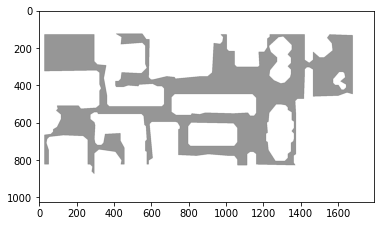

In [14]:
navmesh_settings = habitat_sim.NavMeshSettings()
navmesh_settings.set_defaults()
navmesh_settings.agent_radius = 0.2
navmesh_settings.agent_height = 0.88
navmesh_settings.agent_max_climb = 0.1
env._sim.recompute_navmesh(env._sim.pathfinder, env._sim.navmesh_settings, False)

top_down_map = maps.get_topdown_map(
    env._sim.pathfinder,
    env._sim.get_agent(0).state.position[1],
    1024
)

top_down_map = maps.colorize_topdown_map(top_down_map)
agent_position = env._sim.get_agent_state().position
a_x, a_y = maps.to_grid(
    agent_position[2],
    agent_position[0],
    top_down_map.shape[0:2],
    sim=env._sim,
)

episode = env.current_episode
object_positions = [obj.position for obj in episode.objects]
goal_positions = [obj.position for obj in episode.goals]

grid_object_positions = []
grid_goal_positions = []

for i, obj_pos in enumerate(object_positions):
    tdm_pos = maps.to_grid(
        obj_pos[2],
        obj_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )
    grid_object_positions.append(tdm_pos)

# draw the objectgoal positions.
for i, goal_pos in enumerate(goal_positions):
    tdm_pos = maps.to_grid(
        goal_pos[2],
        goal_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    grid_goal_positions.append(tdm_pos)
    
# top_down_map = maps.draw_agent(
#     image=top_down_map,
#     agent_center_coord=[a_x, a_y],
#     agent_rotation=metrics["top_down_map"]["agent_angle"],
#     agent_radius_px=min(top_down_map.shape[0:2]) / 32,
# )

# top_down_map = maps.draw_object_info(top_down_map, grid_object_positions, grid_goal_positions)

plt.imshow(top_down_map)

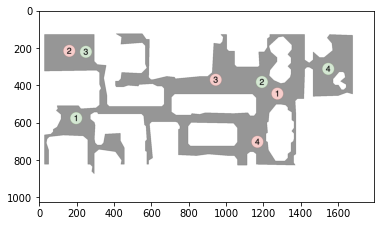

In [18]:
top_down_map = maps.draw_object_info(top_down_map, grid_object_positions, suffix="")
top_down_map = maps.draw_object_info(top_down_map, grid_goal_positions, suffix="g")

plt.imshow(top_down_map)

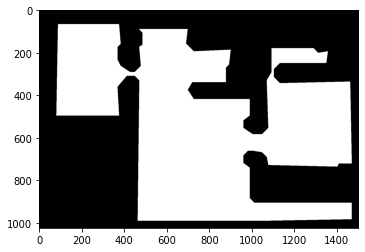

In [75]:
tdmap = top_down_map[:, :, 0]
tdmap[tdmap < 200] = 0
tdmap = np.invert(tdmap)
plt.imshow(tdmap, cmap="gray")

In [26]:
np.random.shuffle(np.arange(1, 5))

In [27]:
np.random.shuffle?

Docstring:
shuffle(x)

Modify a sequence in-place by shuffling its contents.

This function only shuffles the array along the first axis of a
multi-dimensional array. The order of sub-arrays is changed but
their contents remains the same.

.. note::
    New code should use the ``shuffle`` method of a ``default_rng()``
    instance instead; see `random-quick-start`.

Parameters
----------
x : array_like
    The array or list to be shuffled.

Returns
-------
None

See Also
--------
Generator.shuffle: which should be used for new code.

Examples
--------
>>> arr = np.arange(10)
>>> np.random.shuffle(arr)
>>> arr
[1 7 5 2 9 4 3 6 0 8] # random

Multi-dimensional arrays are only shuffled along the first axis:

>>> arr = np.arange(9).reshape((3, 3))
>>> np.random.shuffle(arr)
>>> arr
array([[3, 4, 5], # random
       [6, 7, 8],
       [0, 1, 2]])
Type:      builtin_function_or_method
